# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_recall_fscore_support

from sklearn.svm import SVC
from tqdm import tqdm
import torch

from IPython.display import clear_output

try:
    import MKLpy
except ModuleNotFoundError:
    !pip install MKLpy
    clear_output()
    import MKLpy

from MKLpy.utils.validation import get_scorer
from MKLpy.model_selection import cross_val_score
from MKLpy.preprocessing import kernel_normalization, binarization
from MKLpy.metrics import pairwise
from MKLpy.algorithms import EasyMKL
from MKLpy.model_selection import train_test_split

clear_output()

In [ ]:
try:
    import optuna
except ModuleNotFoundError:
    !pip install --quiet optuna
    clear_output()
    import optuna


# Загрузка и предобработка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# data = pd.read_excel("/content/drive/MyDrive/NeuralNetSch/PeakToPeak_P300_all_diff.xlsx")
data = pd.read_excel("Data/PeakToPeak_P300_all_diff.xlsx")
x = data.drop(['Name', "Diagnosis"], axis=1)
y = data["Diagnosis"]

Mounted at /content/drive


In [ ]:
x_np = np.array(x)
y_np = np.array(y)

In [ ]:
binarizer = binarization.AverageBinarizer()
Xbin = binarizer.fit_transform(x_np, y_np)

In [ ]:
KL = [kernel_normalization(pairwise.monotone_conjunctive_kernel(Xbin, c=c)) for c in range(5)]

# Функции для оценки

In [ ]:
def mkl_custom_cross_val_score(KL, Y, estimator, cv=None, n_folds=4, n_states = 100, scoring = f1_score, random_state=None, shuffle=True):
    '''performs the cross validation'''

    fold_scores = []
    test_scores = []
    scoring = scoring

    for i in tqdm(range(n_states)):
        cv_estim = []
        test_estim = []
        KLtr,KLte,Ytr,Yte = train_test_split(KL, Y, test_size=.3, random_state=i)

        cv  = cv or KFold(n_folds, random_state=42, shuffle=shuffle)
        results = []
        for train, test in cv.split(Ytr,Ytr):
            KL_cv_tr = [K[train][:,train] for K in KLtr]
            KL_cv_te = [K[test ][:,train] for K in KLtr]
            clf = estimator.fit(KL_cv_tr, Ytr[train])
            y_cv_pred = clf.predict(KL_cv_te)
            cv_estim.append(scoring(Ytr[test], y_cv_pred))

            KL_te = [K[:][:,train] for K in KLte]
            y_test_pred = clf.predict(KL_te)
            test_estim.append(scoring(Yte, y_test_pred))


        fold_scores.append(cv_estim)
        test_scores.append(test_estim)

        folds_mean = np.mean(np.array(fold_scores), axis = 0)
        tests_mean = np.mean(np.array(test_scores), axis = 0)

        folds_std = np.std(np.array(fold_scores), axis = 0)
        tests_std = np.std(np.array(test_scores), axis = 0)

        df_for_viz = pd.concat(axis=1, ignore_index=False, objs=[
            pd.DataFrame.from_dict({'estimator': 2*[f'estimator{i}' for i in range(1, n_folds+1)]}),
            pd.DataFrame.from_dict({'condition': n_folds*['fold'] + n_folds*['test']}),
            pd.DataFrame.from_dict({'f1_score': list(folds_mean) + list(tests_mean)}),
            pd.DataFrame.from_dict({'std': list(folds_std) + list(tests_std)})])


    return folds_mean, tests_mean, folds_std, tests_std, df_for_viz


In [ ]:
def viz_cv (df, title = None):
  '''visualzie the cross validation'''
  plt.figure(figsize=(16, 6))
  sns.barplot(x ='estimator', y = 'f1_score', data = df, hue='condition', palette = "pastel")
  plt.errorbar(x=[-0.2, 0.8, 1.8, 2.8],y=df[df['condition'] == 'fold']['f1_score'],
              yerr=df[df['condition'] == 'fold']['std'], fmt='none', c= 'b')
  plt.errorbar(x=[0.2, 1.2, 2.2, 3.2],y=df[df['condition'] == 'test']['f1_score'],
              yerr=df[df['condition'] == 'test']['std'], fmt='none', c= 'r')
  if title != None:
    plt.title(f'{title} f1_score')

In [ ]:
def mkl_test_on_diff_seeds (clf, KL, Y, n_states = 100):
    '''testing on different splits'''
    f1_scores = []
    recall_scores = []
    precision_scores = []
    support_scores = []
    for i in tqdm(range(n_states)):
        KLtr,KLte,Ytr,Yte = train_test_split(KL, Y, test_size=.3, random_state=i)
        clf.fit(KLtr, Ytr)
        y_pred = clf.predict(KLte)
        prec, rec, f, sup = precision_recall_fscore_support (y_pred, Yte)
        f1_scores.append(f)
        recall_scores.append(rec)
        precision_scores.append(prec)
        support_scores.append(sup)
    return classification_report_on_diff_seeds(f1_scores, recall_scores, precision_scores, support_scores)

def classification_report_on_diff_seeds (f1_scores, recall_scores, precision_scores, support_scores):
      df = pd.concat(axis=1, ignore_index=False, objs=[
          pd.DataFrame.from_dict({'classes': [0, 1, 'average']}),
          pd.DataFrame.from_dict({'precision_mean': np.append(np.mean(precision_scores, axis = 0), np.mean(precision_scores))}),
          # pd.DataFrame.from_dict({'precision_std': np.std(precision_scores, axis = 0)}),
          pd.DataFrame.from_dict({'recall_mean': np.append(np.mean(recall_scores, axis = 0), np.mean(recall_scores))}),
          # pd.DataFrame.from_dict({'recall_std': np.std(recall_scores, axis = 0)}),
          pd.DataFrame.from_dict({'f1_mean': np.append(np.mean(f1_scores, axis = 0), np.mean(f1_scores))}),
          # pd.DataFrame.from_dict({'f1_std': np.std(f1_scores, axis = 0)})
          ])


      return df

# Подбор гиперпараметров

In [ ]:
KLtr,KLte,Ytr,Yte = train_test_split(KL, y_np, test_size=.3, random_state=42)

In [ ]:
base_learner = SVC(C=10000, kernel = 'rbf') #"hard"-margin svm

def objective_MKL(trial):

    lam = trial.suggest_float('lamda', 0, 1)

    clf = EasyMKL(learner=base_learner, lam=lam)

    return np.array(cross_val_score(KLtr, Ytr, clf, n_folds=4, scoring='accuracy')).mean()

study_MKL = optuna.create_study(direction='maximize')
study_MKL.optimize(objective_MKL, n_trials=100)

trial_MKL = study_MKL.best_trial

print('MKL Accuracy: {}'.format(trial_MKL.value))
print("Best hyperparameters: {}".format(trial_MKL.params))

[I 2023-11-23 09:37:34,643] A new study created in memory with name: no-name-a953f27e-8536-4d2e-a835-b7dfe89b1b16
[I 2023-11-23 09:37:34,681] Trial 0 finished with value: 0.8583333333333334 and parameters: {'lamda': 0.5353011509368227}. Best is trial 0 with value: 0.8583333333333334.
[I 2023-11-23 09:37:34,715] Trial 1 finished with value: 0.875 and parameters: {'lamda': 0.8065495325667017}. Best is trial 1 with value: 0.875.
[I 2023-11-23 09:37:34,749] Trial 2 finished with value: 0.8166666666666667 and parameters: {'lamda': 0.09175939259403909}. Best is trial 1 with value: 0.875.
[I 2023-11-23 09:37:34,784] Trial 3 finished with value: 0.825 and parameters: {'lamda': 0.11653509021408248}. Best is trial 1 with value: 0.875.
[I 2023-11-23 09:37:34,818] Trial 4 finished with value: 0.9083333333333334 and parameters: {'lamda': 0.032140986881692535}. Best is trial 4 with value: 0.9083333333333334.
[I 2023-11-23 09:37:34,851] Trial 5 finished with value: 0.8166666666666667 and parameters: 

MKL Accuracy: 0.9583333333333334
Best hyperparameters: {'lamda': 0.20015246198592995}


In [ ]:
trial_MKL.params['lamda']

0.20015246198592995

# Кросс-валидация

In [ ]:
base_learner = SVC(C=10000, kernel = 'rbf')
model = EasyMKL(learner=base_learner, lam=trial_MKL.params['lamda'])

In [ ]:
folds_mean, tests_mean, folds_std, tests_std, df_for_viz = mkl_custom_cross_val_score(KL, y_np, model, n_folds=4)

100%|██████████| 100/100 [00:02<00:00, 33.74it/s]


Folds mean = 0.8665021645021641, Folds std = 0.15127857966732158
Tests mean = 0.8665465433259545, Tests std = 0.09615442521075934


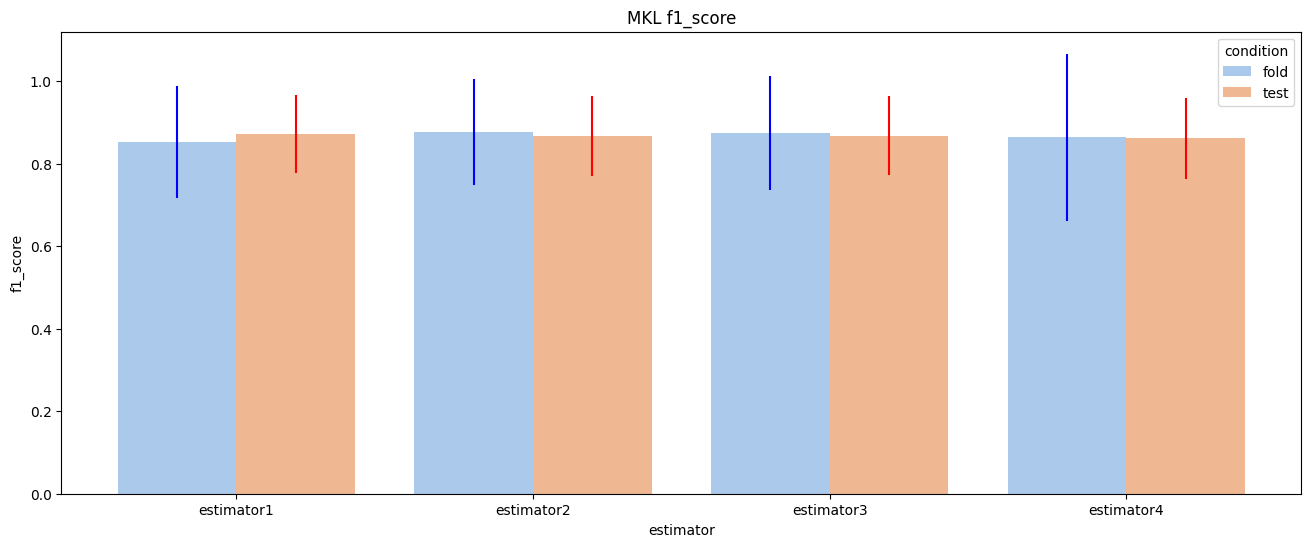

In [ ]:
print(f'Folds mean = {np.mean(folds_mean)}, Folds std = {np.mean(folds_std)}')
print(f'Tests mean = {np.mean(tests_mean)}, Tests std = {np.mean(tests_std)}')

viz_cv(df_for_viz, title = 'MKL')

# Оценка на тесте

In [ ]:
res = mkl_test_on_diff_seeds(model, KL, y_np)

 25%|██▌       | 25/100 [00:00<00:00, 121.76it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 100/100 [00:00<00:00, 125.39it/s]


In [ ]:
res

,classes,precision_mean,recall_mean,f1_mean
0,0,0.807786,0.812857,0.785648
1,1,0.885373,0.883230,0.875670
2,average,0.846579,0.848044,0.830659
